# Betti Curve Plots with AUC analysis

Plots betti curves for *multiple* dgms profiles and includes AUC analysis

- Input: list of pickle files containing dgms (ripser output (np arrays)) up to H2
- Output: Betti curve plot & AUC metrics

Author: @emilyekstrum
<br> 11/26/25

In [2]:
import pickle as pkl
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
import pandas as pd
from matplotlib.colors import to_rgb
import os
import glob
import re
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kruskal, mannwhitneyu
import itertools
import numpy as np

In [3]:
# Import TDA utilities
import sys
from pathlib import Path

# Add the repo root to path if needed
repo_root = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

try:
    from tda_utils import TDADataManager, tda_manager
    print("TDA utilities loaded")
except ImportError as e:
    print(f"Could not import TDA utilities: {e}")
    print("Make sure you're running from the TDA repository.")
    raise

# Initialize or use the global data manager
if tda_manager is not None:
    data_manager = tda_manager
else:
    data_manager = TDADataManager()

# Print summary of available data
data_manager.print_summary()

Data already available.
TDA utilities loaded
TDA Data Manager Summary
Workspace root: /Users/emilyekstrum/repos/TDA
Data directory: /Users/emilyekstrum/repos/TDA/data
  - clean_spike_data_zip: clean_spike_data.zip
  - clean_spike_data_dir: clean_spike_data
      Contains 8 .pkl files
  - cebra_examples: CEBRA_embedding_examples
      Contains 4 .pkl files
  - persistence_examples: persistence_diagram_examples
      Contains 22 .pkl files

Available spike datasets (8):
  • LGNchromatic_gratings.pkl
  • LGNcolor_exchange.pkl
  • LGNdrifting_gratings.pkl
  • LGNluminance_flash.pkl
  • V1chromatic_gratings.pkl
  and 3 more


In [5]:
#utils
# RUN ME

def gaussian_smooth(y, sigma=2.0):
    """Apply Gaussian smoothing to Betti curves
    Args:
        y (np.ndarray): Input Betti curve values.
        sigma (float): Standard deviation for Gaussian kernel.
    Returns:
        np.ndarray: Smoothed Betti curve values."""
    
    if sigma <= 0:
        return y
    try:
        return gaussian_filter1d(y, sigma=sigma, mode="nearest")
    except Exception:
        # or use a simple convolution kernel
        radius = int(max(1, round(3 * sigma)))
        xs = np.arange(-radius, radius + 1, dtype=float)
        kernel = np.exp(-0.5 * (xs / sigma) ** 2)
        kernel /= kernel.sum()
        return np.convolve(y, kernel, mode="same")


def safe_min(arr):
    """ Compute min (ignoring non-finite values)
    Args: 
        arr (np.ndarray): Input array.
    Returns:
        float: Minimum finite value or 0.0 if none exist."""
    
    arr = arr[np.isfinite(arr)]
    return np.min(arr) if arr.size else 0.0


def safe_max(arr):
    """ compute max (ignoring non-finite values)
    Args:
        arr (np.ndarray): Input array.
    Returns:
        float: Maximum finite value or 1.0 if none exist."""
    
    arr = arr[np.isfinite(arr)]
    return np.max(arr) if arr.size else 1.0


def normalize_grid(dgms, n_bins=600):
    """Compute normalized filtration grid across all dimensions.
    
    Args:
        dgms (list of np.ndarray): List of persistence diagrams for each dimension.
        n_bins (int): Number of bins for the grid.
    Returns:
        tuple: (normalized_grid, original_grid, t_min, t_max)
            normalized_grid (np.ndarray): Normalized grid [0,1].   
            original_grid (np.ndarray): Filtration values corresponding to normalized_grid.
            t_min (float): Minimum filtration value.
            t_max (float): Maximum filtration value."""
    
    # flatten one level if dgms is a list of lists 
    flattened = []
    for item in dgms:
        if item is None:
            continue
        # if it is a numpy array representing a diagram, append it
        if isinstance(item, np.ndarray):
            flattened.append(item)
            continue
        # if it is a list/tuple and its first element looks like a diagram (array-like),
        # treat it as a collection of diagrams and extend
        if isinstance(item, (list, tuple)) and len(item) > 0 and not isinstance(item[0], (int, float)):
            if isinstance(item[0], (list, tuple, np.ndarray)):
                flattened.extend(item)
                continue
        # or append the item itself
        flattened.append(item)

    births, deaths = [], []
    for dgm in flattened:
        if dgm is None:
            continue
        arr = np.asarray(dgm)
        if arr.size == 0:
            continue

        # handle single interval stored as 1D array [birth, death]
        if arr.ndim == 1:
            if arr.shape[0] >= 2:
                births.append(np.array([arr[0]], dtype=float))
                deaths.append(np.array([arr[1]], dtype=float))
            continue

        # should be a 2D array: N x 2 (birth, death)
        if arr.shape[1] >= 2:
            births.append(arr[:, 0].astype(float))
            deaths.append(arr[:, 1].astype(float))

    births = np.concatenate(births) if births else np.array([0.0])
    deaths_all = np.concatenate(deaths) if deaths else np.array([1.0])

    t_min = safe_min(births)
    t_max = safe_max(deaths_all)
    if not np.isfinite(t_max):
        t_max = t_min + 1.0

    normalized_grid = np.linspace(0.0, 1.0, n_bins)
    original_grid = t_min + normalized_grid * (t_max - t_min)

    return normalized_grid, original_grid, t_min, t_max


def betti_curve_for_dim(dgm, original_grid):
    """Compute Betti(t) = # intervals alive at each t.
    Args:
        dgm (np.ndarray): Persistence diagram for a single homology group rank.
        original_grid (np.ndarray): Filtration values at which to compute Betti numbers.
    Returns:
        np.ndarray: Betti numbers at each t in original_grid."""
    
    if dgm is None or len(dgm) == 0:
        return np.zeros_like(original_grid)
    arr = np.asarray(dgm)
    if arr.ndim == 1:
        # single interval
        births = np.array([arr[0]])
        deaths = np.array([arr[1]]) if arr.shape[0] > 1 else np.array([np.inf])
    else:
        births, deaths = arr[:, 0], arr[:, 1]

    alive = (births[:, None] <= original_grid[None, :]) & (
        np.isinf(deaths[:, None]) | (deaths[:, None] > original_grid[None, :])
    )
    return alive.sum(axis=0)

# load dgms utils and get file ID info 
def load_dgms(pkl_path):
    """Load persistence diagrams (H0, H1, H2) from pickle file using TDA utils
    Args:
        pkl_path (Path or str): Path to the pickle file.
    Returns:
        list of np.ndarray: List containing H0, H1, H2 diagrams."""
    
    return data_manager.load_persistence_diagrams(pkl_path)


def get_region_from_filename(filepath):
    """Extract region (V1 or LGN) from filename using TDA utils
    Args:
        filepath (str or Path): File path to extract region from.
    Returns:
        str: 'V1', 'LGN', or 'Unknown'."""
    
    info = data_manager.parse_filename_info(filepath)
    return info['region']
    
def get_shuffled_from_filename(filepath):
    """Extract whether data is shuffled from filename using TDA utils
    Args:
        filepath (str or Path): File path to extract shuffle info from.
    Returns:
        bool: True if 'shuffled' in filename, else False."""
    
    info = data_manager.parse_filename_info(filepath)
    return info['is_shuffled']
    
def get_random_null_from_filename(filepath):
    """Extract whether data is random null from filename using TDA utils
    Args:
        filepath (str or Path): File path to extract random null info from.
    Returns:
        bool: True if 'random' in filename, else False."""
    
    info = data_manager.parse_filename_info(filepath)
    return info['is_random']
    
def get_dimension_from_filename(filepath):
    """Extract embedding dimension from filename using TDA utils
    Args:
        filepath (str or Path): File path to extract dimension from.
    Returns:
        str: Dimension token ('3d', '8d', '24d', '32d') or 'unknown'."""
    
    info = data_manager.parse_filename_info(filepath)
    return info['dimension']
    
# plotting aesthetics utils
def shade_color_toward_white(base_color, factor):
    """Return an RGB tuple blended between white and OG color for 
    dimension
    Args:
        base_color (str or tuple): Base color (e.g., 'blue' or (r,g,b)).
        factor (float): Blend factor between 0.0 (white) and 1.0 (base color).
    Returns:
        tuple: Shaded RGB color."""

    base = np.array(to_rgb(base_color), dtype=float)
    white = np.array([1.0, 1.0, 1.0], dtype=float)
    shaded = base * factor + white * (1.0 - factor)
    return tuple(np.clip(shaded, 0.0, 1.0))


def compute_dim_shade_map(pickle_paths, darkest=1.0, lightest=0.35):
    """Return a mapping dim_token -> shade factor between [darkest, lightest].
    The dims are sorted numerically (3d,8d,24d,32d) so lower dims get darker shades.
    
    Args:
        pickle_paths (list of str): List of pickle file paths.
        darkest (float): Shade factor for darkest dimension.
        lightest (float): Shade factor for lightest dimension.
    Returns:
        dict: Mapping from dimension token to shade factor."""
    
    dims = []
    for p in pickle_paths:
        d = get_dimension_from_filename(p)
        if d not in dims:
            dims.append(d)

    def dim_key(s):
        try:
            return int(s[:-1]) if s.endswith('d') and s[:-1].isdigit() else float('inf')
        except Exception:
            return float('inf')

    dims_sorted = sorted(dims, key=dim_key)
    if len(dims_sorted) == 0:
        return {}
    alphas = np.linspace(darkest, lightest, len(dims_sorted))
    return {d: a for d, a in zip(dims_sorted, alphas)}

# Get Persistence Diagram files (dgms)

In [6]:
# load in persistence diagram files
available_dgms = data_manager.find_files("*.pkl", "persistence_examples")

if available_dgms:
    print(f"{len(available_dgms)} persistence diagram files:")
    
    # group files by metadata
    file_groups = {}
    for path in available_dgms:
        info = data_manager.parse_filename_info(path)
        key = f"{info['region']}_{info['stimulus']}"
        if key not in file_groups:
            file_groups[key] = []
        file_groups[key].append((path, info))
    
    # display results
    for group_name, files in file_groups.items():
        print(f"\n{group_name.replace('_', ' - ')}:")
        for path, info in files[:3]:  # show first 3 per group
            print(f"  • {path.name} ({info['dimension']})")
        if len(files) > 3:
            print(f" and {len(files) - 3} more")
    
    print(f"\nUse the cells below to analyze specific groups or all files together.")
else:
    print("No persistence diagram files found.")
    print("Please run the Ripser notebook first to generate persistence diagrams.")

22 persistence diagram files:

V1 - color - exchange:
  • CEBRA_3d_V1_cex_C153.pkl (3d)
  • CEBRA_3d_V1_color_exchange_C155.pkl (3d)
  • CEBRA_8d_V1_cex_C153.pkl (8d)
 and 11 more

LGN - color - exchange:
  • CEBRA_32d_LGN_cex_C153.pkl (32d)
  • CEBRA_3d_LGN_cex_C153.pkl (3d)
  • CEBRA_8d_LGN_cex_C159.pkl (8d)
 and 5 more

Use the cells below to analyze specific groups or all files together.


# Or select files based on criteria

In [7]:
# file selection based on criteria
if available_dgms:
    # config - modify these to select different files
    target_region = "LGN"  # "LGN", "V1", or "all"
    target_mouse = "C153"   # specific mouse ID, or "all"
    target_stimulus = "color_exchange"  # stimulus type, or "all"
    target_dimensions = ["3d", "8d", "24d", "32d"]  # embedding dimensions to include
    
    print(f"File criteria:")
    print(f"  Region: {target_region}")
    print(f"  Mouse: {target_mouse}")
    print(f"  Stimulus: {target_stimulus}")
    print(f"  Dimensions: {target_dimensions}")
    
    # filter files based on criteria
    selected_files = []
    for path in available_dgms:
        info = data_manager.parse_filename_info(path)
        
        # apply filters
        if target_region != "all" and info['region'] != target_region:
            continue
        if target_mouse != "all" and info['mouse_id'] != target_mouse:
            continue
        if target_stimulus != "all" and info['stimulus'] != target_stimulus:
            continue
        if info['dimension'] not in target_dimensions:
            continue
        
        selected_files.append(str(path))
    
    print(f"\n{len(selected_files)} files matching criteria:")
    for i, filepath in enumerate(selected_files, 1):
        print(f"  {i}. {Path(filepath).name}")
    
    # store for plotting
    pickle_dgms_files = selected_files
    
    if not selected_files:
        print("\nNo files match the criteria. Try adjusting the filters.")
        
else:
    pickle_dgms_files = []
    print("No persistence diagram files available.")

File criteria:
  Region: LGN
  Mouse: C153
  Stimulus: color_exchange
  Dimensions: ['3d', '8d', '24d', '32d']

4 files matching criteria:
  1. CEBRA_32d_LGN_cex_C153.pkl
  2. CEBRA_3d_LGN_cex_C153.pkl
  3. CEBRA_24d_LGN_cex_C153.pkl
  4. CEBRA_8d_LGN_cex_C153.pkl


In [13]:
# utils
# RUN ME

def plot_multiple_betti_curves(pickle_paths, bins=600, sigma=2.0, title=None, savepath=None):
    """Plot multiple Betti curves overlaid
    
    Args:
        pickle_paths (list of str): List of pickle file paths.
        bins (int): Number of bins for the Betti curve.
        sigma (float): Standard deviation for Gaussian smoothing.
        title (str or None): Plot title.
        savepath (str or None): Path to save the plot."""
    
    plt.figure(figsize=(10, 6))

    # colors for each homology dimension
    dim_colors = ['blue', 'orange', 'green']
    labels = ["H0", "H1", "H2"]

    # load in all files and get dgms
    all_dgms = [load_dgms(Path(path)) for path in pickle_paths]

    # compute per-dimension shade mapping (3d darkest, then 8d, 24d, 32d lighter)
    dim_to_alpha = compute_dim_shade_map(pickle_paths, darkest=1.0, lightest=0.35)

    seen_legend = set()

    # plot curves for each file
    for i, pickle_path in enumerate(pickle_paths):
        region = get_region_from_filename(pickle_path)
        shuffled = get_shuffled_from_filename(pickle_path)
        random = get_random_null_from_filename(pickle_path)
        dimension = get_dimension_from_filename(pickle_path)

        dgms = all_dgms[i]
        s_grid, t_grid, t_min, t_max = normalize_grid(dgms, n_bins=bins)

        # set line style based on shuffled/random
        linestyle = '--' if (shuffled or random) else '-'

        alpha = dim_to_alpha.get(dimension, 0.6)

        for dim_idx, (label, dgm, base_color) in enumerate(zip(labels, dgms, dim_colors)):
            y = betti_curve_for_dim(dgm, t_grid)
            y_smooth = gaussian_smooth(y, sigma=sigma)
            color_shade = shade_color_toward_white(base_color, alpha)

            legend_label = f"{dimension} {label}"
            use_label = legend_label if legend_label not in seen_legend else None
            if use_label is not None:
                seen_legend.add(legend_label)

            plt.plot(s_grid, y_smooth, linestyle=linestyle, color=color_shade, linewidth=2, label=use_label)

    plt.xlabel("ε (Filtration Diameter)")
    plt.ylabel("Betti numbers (Number of holes/cycles)")
    plt.xlim(0, t_max) 
    #plt.ylim(0, 1)
    plt.title(title)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    if savepath:
        plt.savefig(savepath, dpi=200, bbox_inches="tight")
        print(f"Saved plot to {savepath}")
    plt.show()


def calculate_auc_for_betti_curves(pickle_paths, bins=600, sigma=2.0):
    """Calculate AUC for each Betti curve (each file x each homology dimension).

    Args:
        pickle_paths (list of str): List of pickle file paths.
        bins (int): Number of bins for the Betti curve.
        sigma (float): Standard deviation for Gaussian smoothing.
    Returns:
        dict: Dictionary with keys (file_index, dimension) -> AUC value
        list: List of dictionaries with detailed info for each curve
    """
    
    all_dgms = [load_dgms(Path(path)) for path in pickle_paths]

    # flatten diagrams across files and homology dimensions so normalize_grid()
    # takes an iterable of diagrams
    flattened = [d for dgms in all_dgms for d in dgms]
    normalized_grid, original_grid, t_min, t_max = normalize_grid(flattened, n_bins=bins)
    
    dim_labels = ["H0", "H1", "H2"]
    auc_results = {}
    detailed_results = []
    
    for i, pickle_path in enumerate(pickle_paths):
        region = get_region_from_filename(pickle_path)
        shuffled = get_shuffled_from_filename(pickle_path)
        random = get_random_null_from_filename(pickle_path)
        dimension = get_dimension_from_filename(pickle_path)
        
        dgms = all_dgms[i]
        
        for dim_idx, (label, dgm) in enumerate(zip(dim_labels, dgms)):
            # compute Betti curve
            y = betti_curve_for_dim(dgm, original_grid)
            y_smooth = gaussian_smooth(y, sigma=sigma)
            
            # calculate AUC over normalized_grid
            auc_value = np.trapezoid(y_smooth, normalized_grid)
            
            # store results
            key = (i, dim_idx)
            auc_results[key] = auc_value
            
            # really detailed output 
            detailed_results.append({
                'file_index': i,
                'filename': Path(pickle_path).name,
                'region': region,
                'dimension': dimension,
                'homology_dim': label,
                'shuffled': shuffled,
                'random': random,
                'auc': auc_value
            })
    
    return auc_results, detailed_results

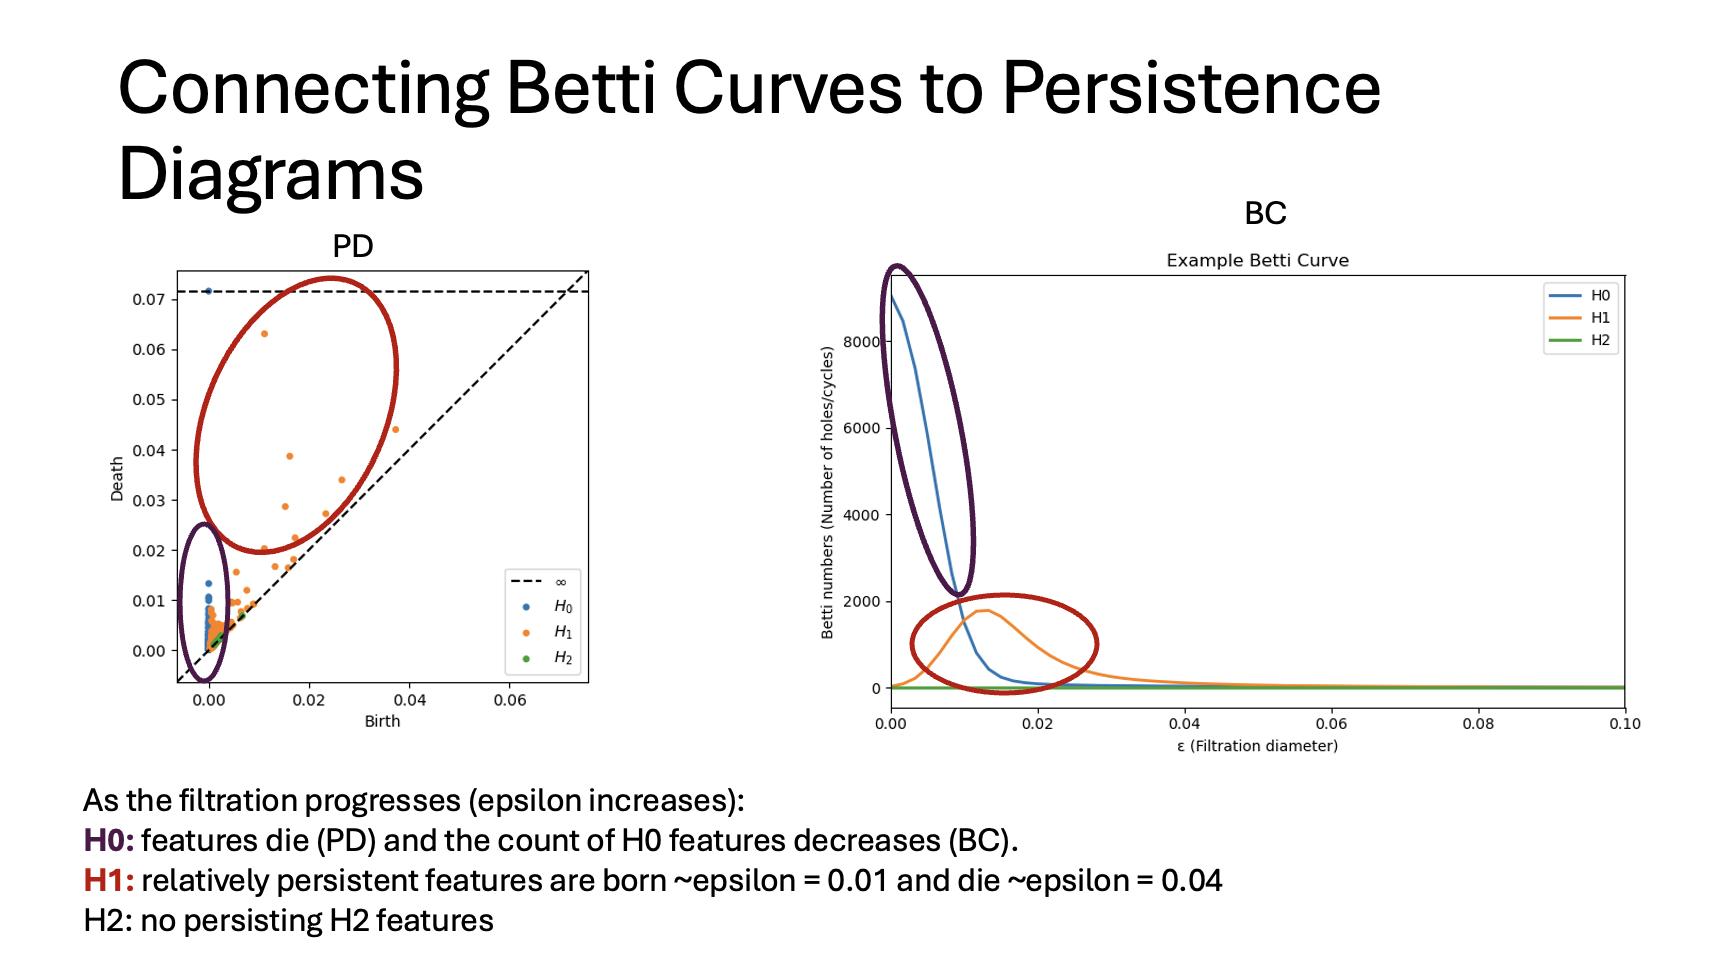

## Plot Betti Curves

Generating Betti curves plot: Smoothed Betti Curves - LGN - Color Exchange - C153


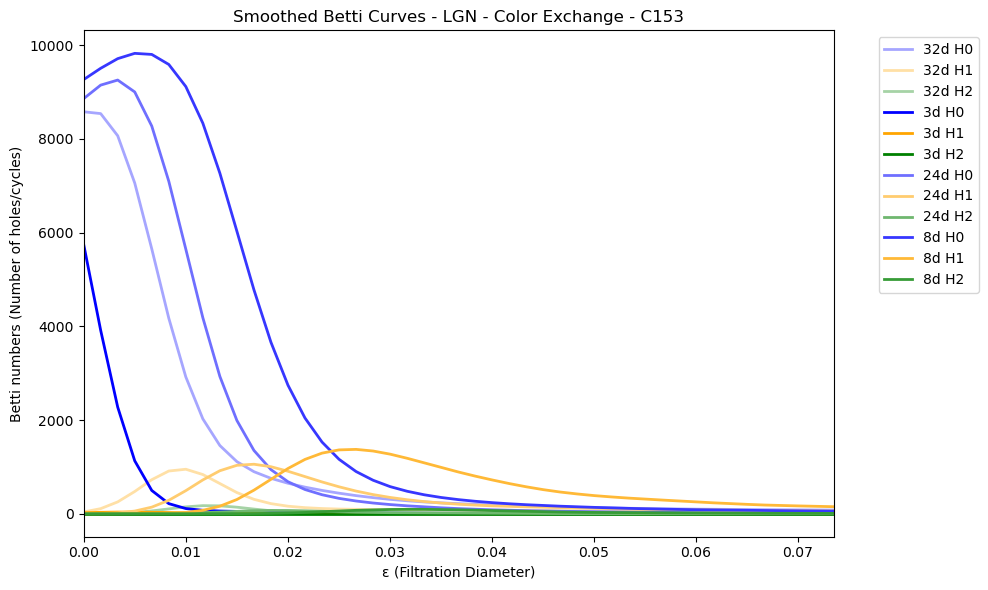

In [14]:
if pickle_dgms_files:
    # title based on file criteria
    title_parts = []
    if target_region != "all":
        title_parts.append(target_region)
    if target_stimulus != "all":
        title_parts.append(target_stimulus.replace('_', ' ').title())
    if target_mouse != "all":
        title_parts.append(target_mouse)
    
    plot_title = f"Smoothed Betti Curves - {' - '.join(title_parts)}" if title_parts else "Smoothed Betti Curves"
    
    print(f"Generating Betti curves plot: {plot_title}")
    
    # plot
    plot_multiple_betti_curves(
        pickle_paths=pickle_dgms_files, 
        bins=600, 
        sigma=2.0, 
        title=plot_title
    )
else:
    print("No files selected for plotting. Check the file selection above.")

In [15]:
# calculate and display AUC for each Betti curve
if pickle_dgms_files:
    auc_dict, detailed_results = calculate_auc_for_betti_curves(
        pickle_paths=pickle_dgms_files, 
        bins=600, 
        sigma=2.0
    )
    
    df_auc = pd.DataFrame(detailed_results)
    
    print(f"\nAUC Summary:")
    print(f"Total curves analyzed: {len(detailed_results)}")
    
    # Display the AUC table
    print("\nAUC Table:")
    display(df_auc)
    
    # Uncomment below to save AUC results
    # auc_filename = f"betti_auc_results_{target_region}_{target_stimulus}.csv"
    # auc_output_path = data_manager.get_output_path(auc_filename, 'analysis_results')
    # df_auc.to_csv(auc_output_path, index=False)
    # print(f"\nAUC results saved to: {auc_output_path.name}")
    
else:
    print("No files available for AUC calculation.")


AUC Summary:
Total curves analyzed: 12

AUC Table:


,file_index,filename,region,dimension,homology_dim,shuffled,random,auc
0,0,CEBRA_32d_LGN_cex_C153.pkl,LGN,32d,H0,False,False,73.183639
1,0,CEBRA_32d_LGN_cex_C153.pkl,LGN,32d,H1,False,False,26.409015
2,0,CEBRA_32d_LGN_cex_C153.pkl,LGN,32d,H2,False,False,4.283806
3,1,CEBRA_3d_LGN_cex_C153.pkl,LGN,3d,H0,False,False,18.402337
4,1,CEBRA_3d_LGN_cex_C153.pkl,LGN,3d,H1,False,False,3.154424
5,1,CEBRA_3d_LGN_cex_C153.pkl,LGN,3d,H2,False,False,0.000000
6,2,CEBRA_24d_LGN_cex_C153.pkl,LGN,24d,H0,False,False,115.383973
7,2,CEBRA_24d_LGN_cex_C153.pkl,LGN,24d,H1,False,False,32.038397
8,2,CEBRA_24d_LGN_cex_C153.pkl,LGN,24d,H2,False,False,1.120200
9,3,CEBRA_8d_LGN_cex_C153.pkl,LGN,8d,H0,False,False,79.554257


## AUC Analysis Plots

/var/folders/st/2v00q15s7bb4yr2r5ghl_42r0000gn/T/ipykernel_92395/1647521307.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='homology_dim', y='auc', data=df_auc, ax=ax00, palette='rocket')
/var/folders/st/2v00q15s7bb4yr2r5ghl_42r0000gn/T/ipykernel_92395/1647521307.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='dimension', y='auc', data=df_auc, ax=ax01, order=dim_order, palette='rocket')


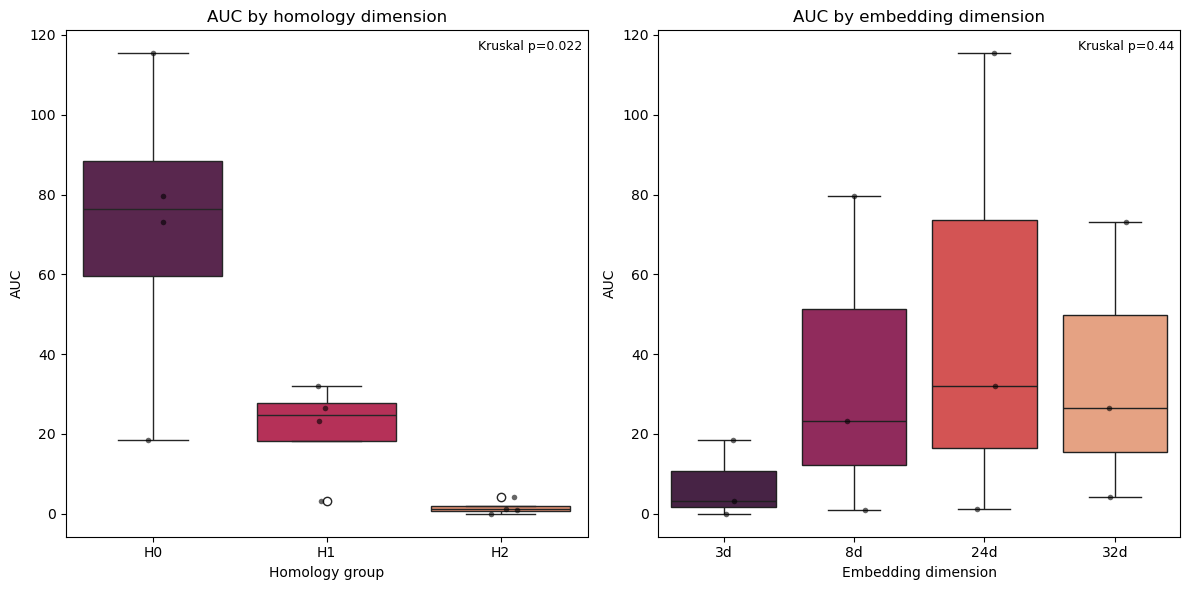

In [16]:
if pickle_dgms_files and 'df_auc' in locals() and not df_auc.empty:
    
    # p-value to star symbols function
    def p_to_stars(p):
        if p < 0.001:
            return '***'
        if p < 0.01:
            return '**'
        if p < 0.05:
            return '*'
        return 'ns'
    
    def dim_order_key(s):
        try:
            return int(s[:-1]) if isinstance(s, str) and s.endswith('d') and s[:-1].isdigit() else float('inf')
        except Exception:
            return float('inf')

    dim_order = sorted(df_auc['dimension'].unique(), key=dim_order_key)
    hom_order = sorted(df_auc['homology_dim'].unique())

    fig, axes = plt.subplots(1, 2, figsize=(12,6))
    ax00 = axes[0]
    ax01 = axes[1]

    # left plot: homology groups boxplot
    try:
        sns.boxplot(x='homology_dim', y='auc', data=df_auc, ax=ax00, palette='rocket')
        sns.stripplot(x='homology_dim', y='auc', data=df_auc, ax=ax00, color='k', size=4, jitter=True, alpha=0.6)
    except Exception:
        groups = df_auc.groupby('homology_dim')['auc'].apply(list)
        labels = list(groups.index)
        ax00.boxplot(groups.tolist(), labels=labels)

    # kruskal-wallis test across homology dims
    hom_groups = [df_auc[df_auc['homology_dim'] == g]['auc'].dropna().values for g in hom_order]
    try:
        kr_stat, kr_p = kruskal(*[g for g in hom_groups if len(g) > 0])
    except Exception:
        kr_p = 1.0
    ax00.set_title(f'AUC by homology dimension')
    ax00.set_xlabel('Homology group')
    ax00.set_ylabel('AUC')
    ax00.text(0.99, 0.98, f'Kruskal p={kr_p:.2g}', transform=ax00.transAxes, ha='right', va='top', fontsize=9)

    # right plot: embedding dimension boxplot
    try:
        sns.boxplot(x='dimension', y='auc', data=df_auc, ax=ax01, order=dim_order, palette='rocket')
        sns.stripplot(x='dimension', y='auc', data=df_auc, ax=ax01, order=dim_order, color='k', size=4, jitter=True, alpha=0.6)
    except Exception:
        groups2 = df_auc.groupby('dimension')['auc'].apply(list)
        labels2 = dim_order
        ax01.boxplot([groups2.get(l, []) for l in labels2], labels=labels2)

    emb_groups = [df_auc[df_auc['dimension'] == g]['auc'].dropna().values for g in dim_order]
    try:
        kr_stat2, kr_p2 = kruskal(*[g for g in emb_groups if len(g) > 0])
    except Exception:
        kr_p2 = 1.0
    ax01.set_title('AUC by embedding dimension')
    ax01.set_xlabel('Embedding dimension')
    ax01.set_ylabel('AUC')
    ax01.text(0.99, 0.98, f'Kruskal p={kr_p2:.2g}', transform=ax01.transAxes, ha='right', va='top', fontsize=9)

    plt.tight_layout()
    
    # uncomment to save the plot
    # plot_filename = f"auc_analysis_{target_region}_{target_stimulus}.png"
    # plot_output_path = data_manager.get_output_path(plot_filename, 'analysis_results')
    # plt.savefig(plot_output_path, dpi=200, bbox_inches='tight')
    # print(f"AUC analysis plot saved to: {plot_output_path.name}")
    
    plt.show()

else:
    print("No AUC data available for plotting.")